### data augmentation. 
ref: https://github.com/pytorch/vision/blob/main/references/segmentation/transforms.py 


In [1]:
import cv2
import time
import torch
import random
import numpy as np 
from glob import glob
import rasterio as rio 
from notebooks import config
from utils.imgShow import imsShow 
from utils.dataloader import SceneArraySet, PatchPathSet
from torchvision.transforms import v2
import torchvision.transforms.functional as TF
from utils.dataloader import read_scenes  
from utils.data_aug import GaussianNoise

In [2]:
patch_size = 512  ## patch size setting
### traset
paths_scene_tra, paths_truth_tra = config.paths_scene_tra, config.paths_truth_tra
paths_dem_tra = config.paths_dem_tra
print(f'train scenes: {len(paths_scene_tra)}')
### valset
paths_valset = sorted(glob(f'data/dset/valset/patch_{patch_size}/*'))  ## for model prediction 
print(f'vali patch: {len(paths_valset)}')

train scenes: 48
vali patch: 434


In [3]:
scenes_arr, truths_arr, scenes_lat = read_scenes(paths_scene_tra[0:5], 
                                        paths_truth_tra[0:5], 
                                        paths_dem_tra[0:5])


In [4]:
scene_truth = np.concatenate([scenes_arr[0], truths_arr[0][:, :, np.newaxis]], axis=-1)
print(scene_truth.shape)  # (H, W, C+2) 


(1737, 1713, 8)


### numpy to tensor

In [5]:
print(scene_truth.shape)
scene_truth_ = v2.ToImage()(scene_truth)  # to PIL Image
print(scene_truth_.shape)


(1737, 1713, 8)
torch.Size([8, 1737, 1713])


### random cropping

In [ ]:
crop_random = v2.RandomCrop(size=(512, 512))
patch_ptruth = crop_random(scene_truth_)
patch, pdem, ptruth = patch_ptruth[0:6], patch_ptruth[6:7], patch_ptruth[7:]  ## separate patch and truth
patch, pdem, ptruth = patch.numpy().transpose((1, 2, 0)), pdem.numpy().transpose((1, 2, 0)), ptruth.numpy().transpose((1, 2, 0))


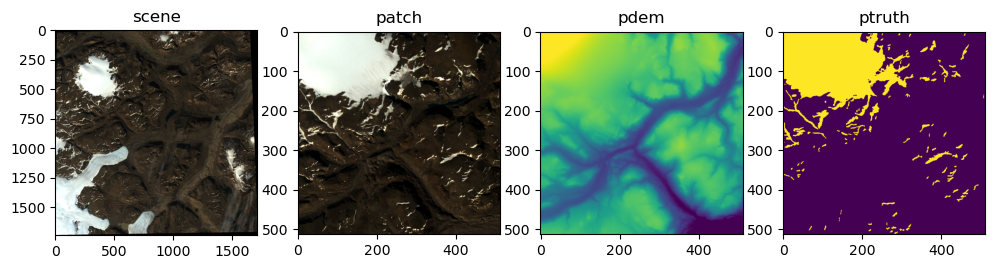

In [7]:
imsShow([scene_truth_.numpy().transpose((1, 2, 0)), patch, pdem, ptruth], 
              clip_list=[2,2,2,2], 
              img_name_list=['scene','patch','pdem','ptruth'], 
              figsize=(12, 3)) 


### random augmentation
random flipping   
random noisy   
random rotation   


In [ ]:
# transform_random = v2.RandomHorizontalFlip(p=0.8)  
# transform_random = v2.RandomVerticalFlip(p=0.8)  
# transform_random = v2.RandomApply([v2.RandomRotation(degrees=180)], p=0.8) 
transform_random = GaussianNoise(mean = 0.0, sigma_max_img=0.1, 
                                      sigma_max_dem=0, p=0.3)  


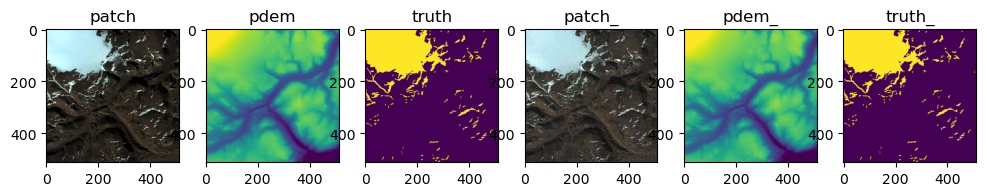

In [9]:
patch_ptruth_ = transform_random(patch_ptruth) 
patch_, pdem_, ptruth_ = patch_ptruth_[0:6], patch_ptruth_[6:7], patch_ptruth_[7:]  
patch_, pdem_, ptruth_ = patch_.numpy().transpose((1, 2, 0)), pdem_.numpy().transpose((1, 2, 0)), ptruth_.numpy().transpose((1, 2, 0))
col_bands_list = [(3,2,1),(0,0,0),(0,0,0),(3,2,1),(0,0,0),(0,0,0)]
imsShow([patch, pdem, ptruth, patch_, pdem_, ptruth_], 
              clip_list=[2, 2, 2, 2, 2, 2], 
              img_name_list=['patch','pdem','truth','patch_','pdem_','truth_'], 
              color_bands_list=col_bands_list,
              figsize=(12, 3));


### merge all data augmentation

In [ ]:
## combine transforms
transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomCrop(size=(512, 512)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    GaussianNoise(mean = 0.0, sigma_max_img=0.2, sigma_max_dem=0, p=0.3),  
    v2.RandomApply([v2.RandomRotation(degrees=180)], p=0.5),    
])


In [288]:
patch_dem_truth_ = transforms(scene_truth)
patch_, dem_, ptruth_ = patch_dem_truth_[0:6], patch_dem_truth_[6:7], patch_dem_truth_[7:]  ## separate patch and truth
patch_, dem_, ptruth_ = patch_.numpy().transpose((1, 2, 0)), dem_.numpy().transpose((1, 2, 0)), ptruth_.numpy().transpose((1, 2, 0))


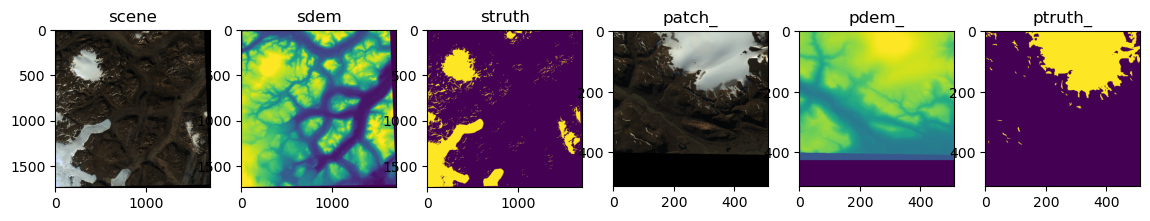

In [289]:
scene, sdem, struth = scene_truth[:,:,0:6], scene_truth[:,:,6:7], scene_truth[:,:,7:8]
imsShow([scene, sdem, struth, patch_, dem_, ptruth_], 
              clip_list=[0, 2, 2, 0, 2, 2], 
              img_name_list=['scene','sdem','struth','patch_','pdem_','ptruth_'], 
              figsize=(14, 3)) 
